In [2]:
import cv2 as cv

from matplotlib import pyplot as plt

import numpy as np

In [3]:
nonoise_vid = cv.VideoCapture('./1tagvideo.mp4')
if (nonoise_vid.isOpened() == False):
	print("Error opening the video file")
else:
  # Get frame rate information

  fps = int(nonoise_vid.get(5))
  print("Frame Rate : ",fps,"frames per second")	

  # Get frame count
  frame_count = nonoise_vid.get(7)
  print("Frame count : ", frame_count)


Frame Rate :  26 frames per second
Frame count :  787.0


In [4]:
frames = []
while(nonoise_vid.isOpened()):
	# nonoise_vid.read() methods returns a tuple, first element is a bool 
	# and the second is frame
  ret, frame = nonoise_vid.read()
  if ret == True:
    #Split the channels and invert color of the frame as we are only interested in the red channel
    frames.append(frame)
  else:
    break

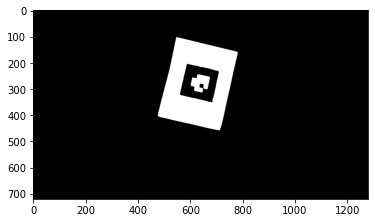

In [5]:
img= cv.cvtColor(frames[0],cv.COLOR_BGR2GRAY)
img = cv.resize(img,(1280,720))
_, img = cv.threshold(img,200,255,cv.THRESH_BINARY)
# img = np.rot90(img)
plt.imshow(img,"gray")

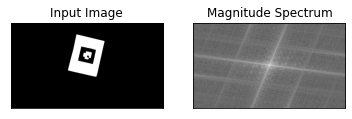

In [6]:
# img = cv.cvtColor(frames[0], cv.COLOR_BGR2GRAY)
ifft1 = np.fft.ifftshift(img)
f = np.fft.fft2(ifft1)
fshift = np.fft.fftshift(f)
# magnitude_spectrum = 20*np.log(np.abs(fshift))
magnitude_spectrum = np.log(np.abs(fshift))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [25]:
rows, cols = fshift.shape[0], fshift.shape[1]
x_c, y_c = int(fshift.shape[0]/2),int(fshift.shape[1]/2)
size = 100
hp_mask = np.ones(fshift.shape)
xgrid,ygrid = np.ogrid[:rows,:cols]
mask = (xgrid-x_c)**2 + (ygrid-y_c)**2 <= size**2
hp_mask[mask] = 0
edge_image = (fshift*hp_mask)
edge_image = np.fft.ifft2(edge_image)
edge_image = np.fft.ifftshift(edge_image)

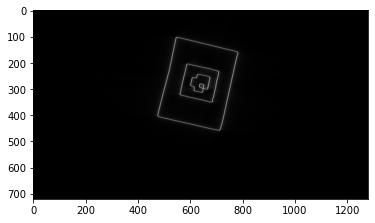

In [26]:
plt.imshow(np.abs(edge_image),"gray")

In [33]:
edge_image = cv.Canny(edge_image,50,200,None,3)

TypeError: must be real number, not NoneType

In [32]:
lines = cv.HoughLines(edge_image, 1, np.pi / 180, 150, None, 0, 0)

TypeError: Expected cv::UMat for argument 'image'